In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy import misc, ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## Load images and  transform them into feature vectors

In [2]:
x = []
y = []

for j in range(1,11):#63
    for k in range(1,56):#56
        if j<=9 and k<=9:
            image_filename = '../Datasets/Hand_drawn_characters/Sample00%d/img00%d-00%d.png'%(j,j,k)
        if j<=9 and k>9:
            image_filename = '../Datasets/Hand_drawn_characters/Sample00%d/img00%d-0%d.png'%(j,j,k)
        if j>9 and k<=9:
            image_filename = '../Datasets/Hand_drawn_characters/Sample0%d/img0%d-00%d.png'%(j,j,k)
        if j>9 and k>9:
            image_filename = '../Datasets/Hand_drawn_characters/Sample0%d/img0%d-0%d.png'%(j,j,k)
        #reading the image
        image = misc.imread(image_filename, flatten=True)
        #resizing 0.20 => from 900*1200 to 180*240
        image = misc.imresize(image,0.20) 
        #finding the object
        objs = ndimage.find_objects(image - image.max()) #use of negative image to find the object
        image = image[int(objs[0][0].start):int(objs[0][0].stop),int(objs[0][1].start):int(objs[0][1].stop)]
        #zooming to 90x60
        h = 91.0/image.shape[0]
        l = 61.0/image.shape[1]
        image = ndimage.zoom(image,(h,l))
        #flattening to one dimensional vector
        image = image[0:90,0:60].reshape(90*60).astype('float32')
        x.append(image)
        y.append(j)

## Convert lists to arrays

In [3]:
x = np.array(x)
x.shape

(550, 5400)

In [4]:
y = np.array(y)
y.shape

(550,)

## Split into train and test sets

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

## Scale the features

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Dimensionality Reduction with PCA

In [7]:
pca = PCA(n_components=30)
x_train_reduced = pca.fit_transform(x_train)
x_test_reduced = pca.transform(x_test)

In [8]:
pca.explained_variance_ratio_

array([ 0.1050298 ,  0.09610634,  0.0720462 ,  0.06861351,  0.05490972,
        0.04660005,  0.039905  ,  0.0320131 ,  0.03032806,  0.02238169,
        0.02171815,  0.01851993,  0.01694439,  0.01529647,  0.01441361,
        0.01394854,  0.01139868,  0.01058782,  0.01033299,  0.00979238,
        0.00908763,  0.00886928,  0.00830252,  0.00767871,  0.00719366,
        0.00687708,  0.00639373,  0.00625859,  0.00574421,  0.00538078])

In [9]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.1050298 ,  0.20113615,  0.27318235,  0.34179585,  0.39670557,
        0.44330562,  0.48321061,  0.51522371,  0.54555177,  0.56793346,
        0.5896516 ,  0.60817154,  0.62511593,  0.64041239,  0.654826  ,
        0.66877454,  0.68017323,  0.69076105,  0.70109404,  0.71088642,
        0.71997405,  0.72884333,  0.73714584,  0.74482456,  0.75201821,
        0.7588953 ,  0.76528902,  0.77154762,  0.77729182,  0.78267261])

## Hyperparameter optimization with cross-validation

In [10]:
estimator =  RandomForestClassifier(n_estimators=100)

parameters ={'max_depth': np.arange(1,21)}

grid_search = GridSearchCV(estimator, parameters, cv =5, n_jobs=-1)
grid_search.fit(x_train_reduced, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [11]:
grid_search.best_score_

0.93478260869565222

In [12]:
grid_search.best_params_

{'max_depth': 8}

## Make predictions using the best model

In [13]:
model = grid_search.best_estimator_

In [14]:
y_pred = model.predict(x_test_reduced)

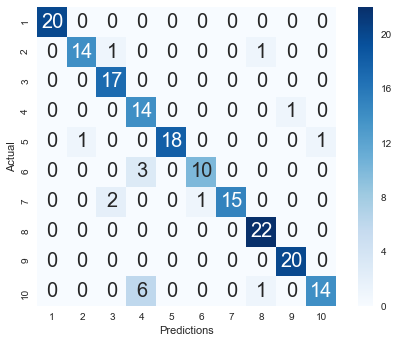

In [15]:
table = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predictions'])

sbn.heatmap(table, cbar=True, cmap='Blues',annot=True, square=True, fmt='d', annot_kws={'size': 20})

plt.show()

## Evaluate the best model

In [16]:
model.score(x_test_reduced,y_test)

0.90109890109890112